Описание содержания проекта по разработке сервиса предсказания суточного объема потребления и транспортировки природного газа.

Цель проекта: Разработка сервиса необходима для повышения уровня прогнозирования объемов транспортировки и потребления природного газа с последующим увеличением показателей планово-экономической деятельности.

Описание сервиса: Продукт будет построен на основе ML алгоритма, позволяющего прогнозировать объемы транспортировки и потребления природного газа с точностью выше, чем алгоритм, основанный на расчете средней величины. В качестве данных, на которых будет обучаться модель мы используем датасеты, содержащие информацию о потреблении ПГ за периоды с 2016 по 2019 годы. 

Структура исходных датасетов следующая:
Дата потребления
	Потребитель 1	…Потребитель N	Группа потребителя
Для получения более точных результатов, датасет дополняем следующими «фичами»:
-	признак выходного/праздничного дня;
-	среднесуточная температура;
-	признак отопительного сезона;
-	другие признаки, генерируемые из вышеперечисленных.

Мы будем анализировать две группы потребителей(14 потребителей):
1 группа состоит из двух крупнейших потрбителей газа(около 13% годового потребления ПГ)
2 группа состоит из 12 крупнейших потребителей газа(около 6% годового потребления ПГ)
Всего порядка 10000 потребителей юридических лиц, таким образом рассматриваемые группы потребителей в общей соповкупности составляют 20 % потребления. 

Задачи проекта:
1)	Произвести EDA, FE
2)	Проверить несколько видов алгоритмов машинного обучения (Логистическая регрессия, XGBoost, Sarima, Prophet)
3)	Получить лучшее метрики в сравнении с расчетом средней величины. Используемые метрики : MAE, MAPE, R2
4)	Разработка модели в продакшн.


Что будем делать.
В процессе будем пробовать два типа алгоритмов: методы анализа временных рядом(Sarima, Prophet), метод машинного обучения XGBoost(в том числе на временном ряду приведенным к стационарному виду)   

In [4]:
#pip install --upgrade xgboost


In [3]:
#pip install --upgrade tensorflow

In [2]:
#pip install prophet

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings; warnings.simplefilter('ignore')
import tensorflow as tf
import math
import xgboost

# Загружаем модуль для разделения датасета:
from sklearn.model_selection import train_test_split

#from fbprophet import prophet

# Загружаем соответствующие методы нормализации:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#different statistical models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from scipy.optimize import minimize

# Загружаем метод создания полиномаиальных признаков:
from sklearn.preprocessing import PolynomialFeatures

# Загружаем модули для работы с датой и временем
from datetime import datetime
from datetime import timedelta

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler


In [82]:
data = pd.read_excel('DataSet_for_model.xlsx', sheet_name='2') 

## Functions used


In [113]:
#прорисовка Boxplot
def get_boxplot(col):
    fig, ax = plt.subplots(figsize = (20, 14))
    sns.boxplot(y= col, data = data)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col)
    plt.show()
    
#удаление выбросов
def cut_emissions(x):
    median = x.median()
    IQR = x.quantile(0.75) - x.quantile(0.25)
    perc25 = x.quantile(0.25)
    perc75 = x.quantile(0.75)
    x = x.loc[x.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    return x

#кросс валидация
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

#тест dikki-fuller
#def adfuller_test(series, signif = 0.05, name ='', verbose = False)
#    r = adfuller(series, autolag = 'AIC')
 #   output = {'test_statistic':round(r[0],4), 'pvalue':round(r[1],4), 'n_lags':round(r[2],4), n_obs:r[3]}
 #   pvalue = output['pvalue']
    
    

## EDA

Изучим полученный датасет

In [6]:
data.shape

(1095, 5)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1095 non-null   datetime64[ns]
 1   holiday            1095 non-null   bool          
 2   temp               1095 non-null   float64       
 3   tep_en_5257087027  1095 non-null   float64       
 4   lukoil_5250043567  1095 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(3)
memory usage: 35.4 KB


Проверим дата сет на пропуски

In [8]:
data.isna().sum().sort_values()

date                 0
holiday              0
temp                 0
tep_en_5257087027    0
lukoil_5250043567    0
dtype: int64

Проверка и удаление столбцов с повторяющимимся неинформативными значениями(более 30 значений)

In [19]:
for col in data.columns: 
    if (len(data[col].unique()) < 30): 
        if(col != 'holiday'):
            data = data.drop(col, axis = 'columns')

#### У нас временные ряды,  вероятнее всего не стационарные. Наша задача перед переадчей рядов в модель SARIMA сделать их стационарными. Для этого выделим  наличие трендов и сезонность.

In [ ]:
# проверка рядов на стационарнсоть с помощью теста Дикки-Фуллера
# для начала визщуализируем временные ряды группы потребителей №1

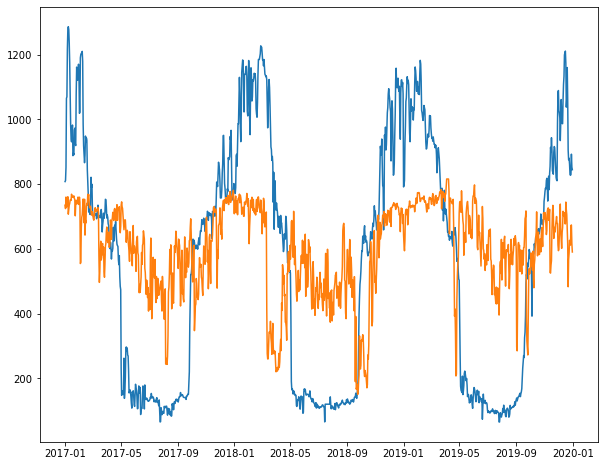

In [33]:
plt.rcParams["figure.figsize"] = 10, 8
plt.plot(data['date'], data['tep_en_5257087027'])
plt.plot(data['date'], data['lukoil_5250043567'])
plt.show()


tep_en_5257087027                        
                   mean      median         std
month                                          
1           1033.091726  1039.95150  125.371019
2           1023.524589  1025.18925  137.899031
3            858.932935   810.29500  163.432550
4            634.766583   637.34425   54.079642
5            183.596823   155.03000   89.161367
6            138.691250   137.98500   21.083266
7            110.368581   111.51400   19.613255
8            110.480355   112.50200   14.232480
9            225.855233   146.49200  146.341974
10           630.509548   630.51300   50.310773
11           808.859633   798.50800  108.073570
12           955.541108   950.06400  134.575514

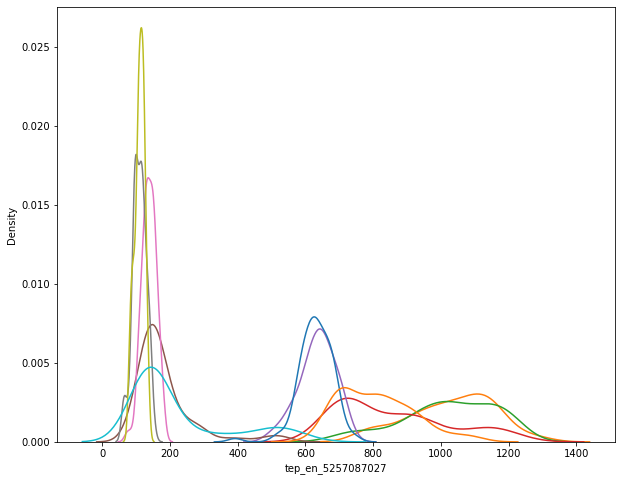

In [67]:
#посомтрим на распределение рядов по дням недели и месяцам
#для этого добавим сначала новые признаки
data['dayofweek'] = data['date'].dt.dayofweek
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month

for i in range(12):
    sns.distplot(data[data['month'] == i]['tep_en_5257087027'], hist = False, label=str(i))
data.groupby('month').agg({'tep_en_5257087027':['mean','median','std']})

In [17]:
#четко прослеживается сезонность и тренд по обоим временным рядам 
#попропбуем избавиться от сезонности и трендов во временных рядах

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1095 non-null   datetime64[ns]
 1   holiday            1095 non-null   bool          
 2   temp               1095 non-null   float64       
 3   tep_en_5257087027  1095 non-null   float64       
 4   lukoil_5250043567  1095 non-null   float64       
 5   dayofweek          1095 non-null   int64         
 6   day                1095 non-null   int64         
 7   month              1095 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(3), int64(3)
memory usage: 61.1 KB


Критерий Дики-Фуллера: p=0.295755


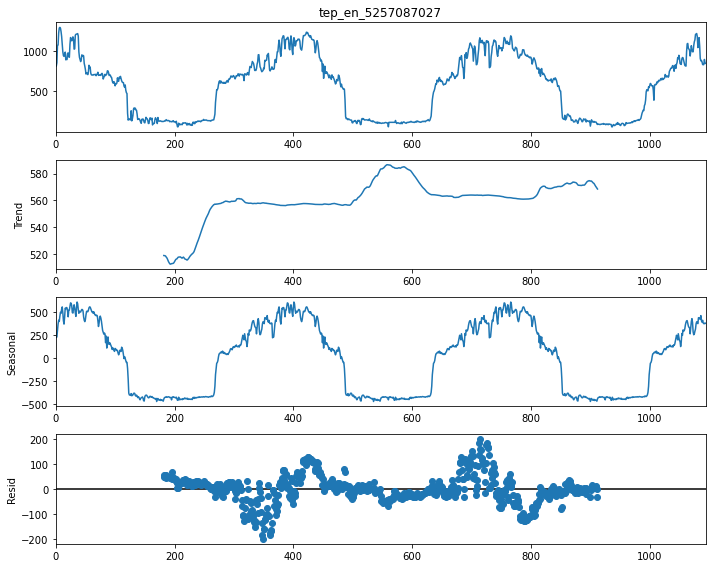

In [68]:
sm.tsa.seasonal_decompose(data['tep_en_5257087027'], freq=365).plot()
print(
    "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['tep_en_5257087027'])[1]
)
#adfuller_test(data['tep_en_5257087027'], signif = 0.05, name = 'tep_en_5257087027', verbose = False)


In [72]:
#нулевая гипотеза о нестационарности не отвергается
# сделаем дифференцирование ряда
data['tep_en_5257087027_diff'] = data['tep_en_5257087027'].diff(12)

Критерий Дики-Фуллера: p=0.000004


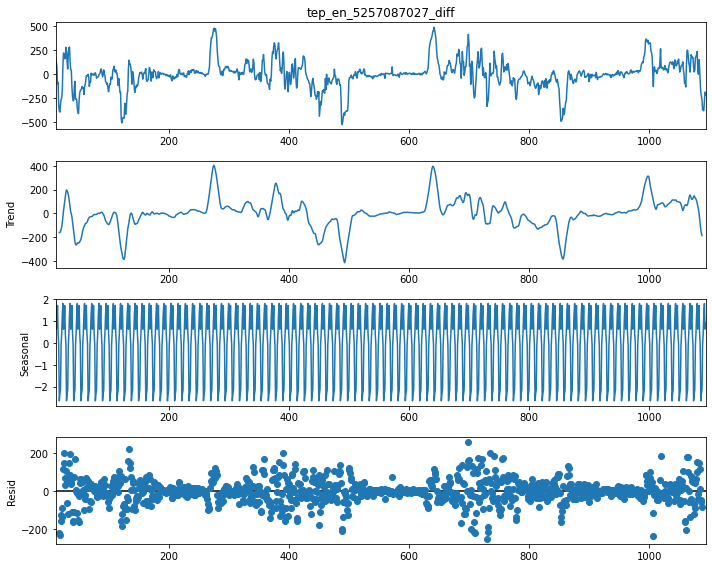

In [73]:
sm.tsa.seasonal_decompose(data['tep_en_5257087027_diff'][12:], freq=12).plot()
print(
    "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['tep_en_5257087027_diff'][12:])[1]
)

## FE

посмотрим на корреляции

In [64]:
#correlation = data.corr()
#plt.rcParams['figure.figsize'] = (25,15)
#sns.heatmap(correlation, annot = True, cmap = 'coolwarm')

In [83]:
#добавим  новые признаки
data['dayofweek'] = data['date'].dt.dayofweek
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month

добавим признак отопительного сезона

In [84]:
data['season'] = data['month'].apply(lambda x: 1 if x > 9 else 1 if x < 5 else 2)

оцифруем столбец 'Признак выходного дня'

In [85]:
label_encoder = LabelEncoder()
data['num_holiday'] = pd.Series(label_encoder.fit_transform(data['holiday']))

In [86]:
data['temperature'] = data['temp']
data.drop(['holiday','date','temp'], inplace = True, axis = 1)


## ML

In [87]:
data

,tep_en_5257087027,lukoil_5250043567,dayofweek,day,month,season,num_holiday,temperature
0,808.011,734.991,6,1,1,1,1,1.3
1,811.360,724.584,0,2,1,1,1,0.6
2,852.364,760.213,1,3,1,1,1,-4.1
3,1065.322,729.123,2,4,1,1,1,-16.5
4,1070.136,738.825,3,5,1,1,1,-10.8
...,...,...,...,...,...,...,...,...
1090,827.355,611.823,4,27,12,1,0,-7.1
1091,830.114,672.302,5,28,12,1,1,-6.5
1092,892.726,673.892,6,29,12,1,1,-5.3
1093,852.529,616.126,0,30,12,1,0,-5.0


In [111]:
#создадим массив для зависимой переменной
y = data.iloc[:,:-7].values

#создадим массив для переменных-признаков]
X = data.iloc[:,2:].values




In [108]:
X

array([[ 8.08011e+02,  7.34991e+02,  6.00000e+00, ...,  1.00000e+00,
         1.00000e+00,  1.30000e+00],
       [ 8.11360e+02,  7.24584e+02,  0.00000e+00, ...,  1.00000e+00,
         1.00000e+00,  6.00000e-01],
       [ 8.52364e+02,  7.60213e+02,  1.00000e+00, ...,  1.00000e+00,
         1.00000e+00, -4.10000e+00],
       ...,
       [ 8.92726e+02,  6.73892e+02,  6.00000e+00, ...,  1.00000e+00,
         1.00000e+00, -5.30000e+00],
       [ 8.52529e+02,  6.16126e+02,  0.00000e+00, ...,  1.00000e+00,
         0.00000e+00, -5.00000e+00],
       [ 8.44816e+02,  5.90427e+02,  1.00000e+00, ...,  1.00000e+00,
         0.00000e+00, -1.00000e-01]])

In [132]:
from sklearn import metrics

performTimeSeriesCV(X, y, 5, mean_absolute_error)

NameError: name 'mean_absolute_percentage_error' is not defined

In [109]:
# разобьем выборку на тестовую и обучаемую(80/20)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
splitCoef = 0.8
X_train, X_test = np.split(X, [int(splitCoef*len(data))])

In [82]:
# обучим модель
from sklearn.linear_model import LinearRegression
model_reg = LinearRegression() #Обозначаем, что наша модель - линейная регрессия
model_reg.fit(X_train,y_train) #обучаем модель на обучающих данных


LinearRegression()

In [81]:
model_boost = xgboost.XGB_forecast()
model_boost.fit(X_train, y_train)

ValueError: y should be a 1d array, got an array of shape (876, 2) instead.

In [79]:
#предскажем значения расходов газа на тестовой выборке
y_pred = model_reg.predict(X_test)
y_pred = model_boost.predict(X_test)


NotFittedError: need to call fit or load_model beforehand

In [83]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [123]:
#оценим ошибку предсказанной величины
from sklearn import metrics  # подгружаем метрики
print('MAE:',metrics.mean_absolute_error(y_test, y_pred),
      'MAPE:', mean_absolute_percentage_error(y_test, y_pred))

NameError: name 'y_test' is not defined

In [1]:
#from sklearn.metrics import f1_score
#f1_score(Y_test, y_pred)

In [87]:
#вычислим коэффициент детерминации
R_2 = metrics.r2_score(y_test, y_pred)
print(R_2)

0.5809081203742348
